In [22]:
import joblib
import pandas as pd
import seaborn as sb
import glob
import matplotlib.pyplot as plt
import truvari
import os
sb.set()

In [27]:
#data = joblib.load("/home/english/science/english/msru/data/genotyping/delme.frame.jl")
data = joblib.load("/home/english/science/english/msru/data/genotyping/sum.jl")

In [28]:
for i in ["gtcls", "minPL", "bayes"]:
    data[i + "Accuracy"] = data[i + "Correct"] / (data[i + "Correct"] + data[i + "Incorrect"])

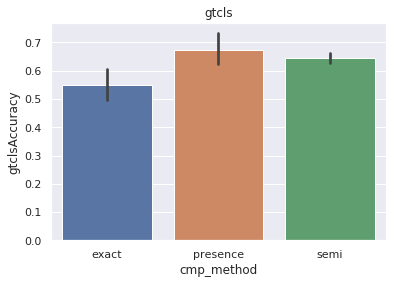

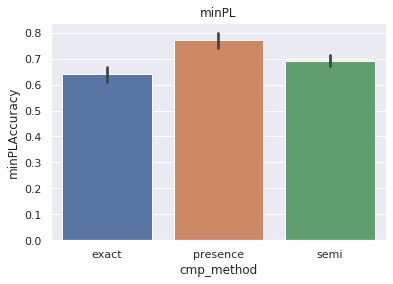

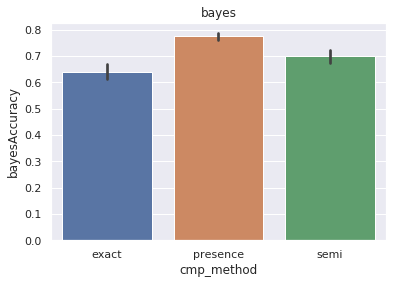

In [29]:
for i in ["gtcls", "minPL", "bayes"]:
    sb.barplot(data=data, x ="cmp_method", y=i + "Accuracy").set(title=i)
    plt.show()

In [30]:
data.to_csv("check.tsv", sep="\t")

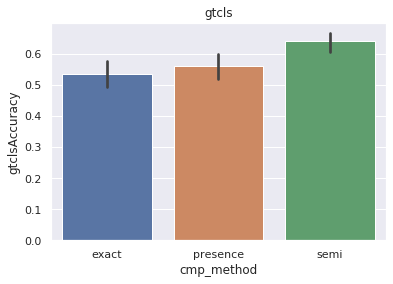

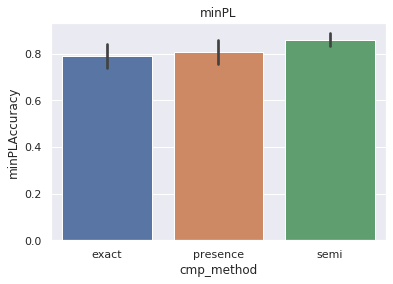

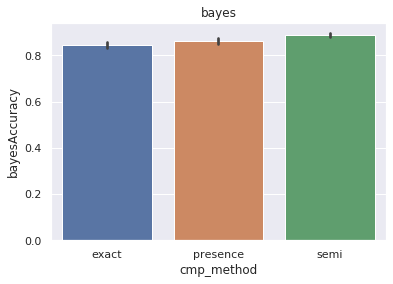

In [16]:
for i in ["gtcls", "minPL", "bayes"]:
    sb.barplot(data=data[data["with_ref"] == False], x ="cmp_method", y=i + "Accuracy").set(title=i)
    plt.show()